## Валидация данных

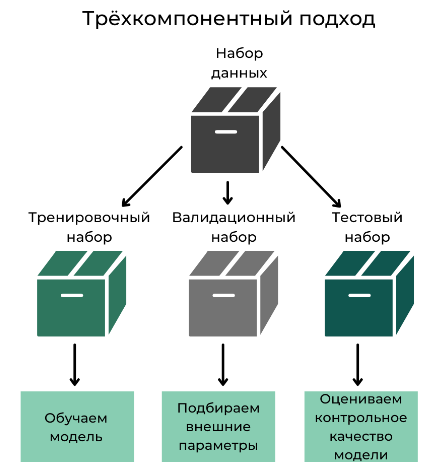

Основные методы: 
* HOLD-OUT;
* K-FOLD;
* LEAVE-ONE-OUT.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

C:\Users\lm137\AppData\Local\Temp\ipykernel_12780\3755730.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #стиль отрисовки seaborn


In [2]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). 

In [4]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [5]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

### HOLD-OUT

Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).

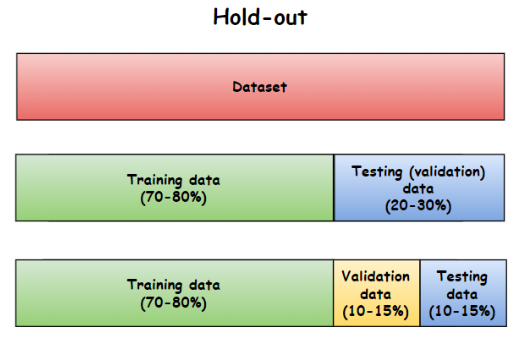

**Преимущества**:
* Очень простой и понятный;
* Чаще всего применяется на больших датасетах, так как требует значительно меньше вычислительных мощностей, чем другие методы.

**Недостатки**:
* Важно помнить, что разбиение производится случайным образом и оценка в этом методе зависит от того, какие наблюдения попали в набор для валидации. Это плохо, так как возможна ситуация, когда распределение целевого признака в тренировочной, валидационной (и тестовой) выборках может значительно различаться, и оценка качества может быть необъективной.

**train_test_split()**:
* ***arrays** — порядковый аргумент с переменным количеством. Набор массивов (это могут быть списки, numpy-массивы, DataFrame), которые подлежат разбиению.
* **test_size** — размер тестовой (валидационной) выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-train_size.
* **train_size** — размер тренировочной выборки. Может быть указан в долях. Определяется автоматически, если параметр test_size передан как 1-test_size.
* **random_state** — число, на основе которого производится генерация случайных чисел.
* **shuffle** — параметр, указывающий, стоит ли перемешивать выборку перед разбиением (по умолчанию True).
* **stratify** — стратифицированное разбиение (о нём мы поговорим в юните по дисбалансу выборки).

In [6]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [7]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


### K-FOLD

Метод k-fold более известен как **кросс-валидация (cross validation)**, или перекрёстный контроль.

**Алгоритм**:
* Разбить исходную выборку на $k$ частей — фолдов (fold).
* Повторять $k$ раз:
    - Обучить модель на $k-1$ частях. Назовём их тренировочными фолдами (training fold). 
    - Произвести оценку качества (вычислить метрику) на оставшейся части. Назовем её валидационным фолдом (validation fold).
* Усреднить значения метрики на валидационных фолдах.

    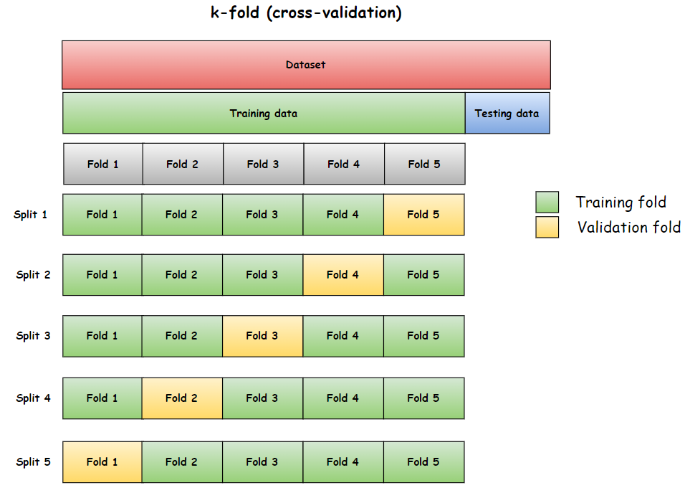

**Преимущества**:
* Подход позволяет получить более устойчивую к выбросам оценку качества модели, так как модель обучается на нескольких независимых наборах данных.
* Значения метрик получаются более объективными, ведь мы обучаем одну модель k раз — у нас получается k независимых друг от друга значений метрики.

**Недостатки**:
* Подход предусматривает, что мы обучаем одну и ту же модель k раз, что, очевидно, плохо сказывается на производительности. Если модель обучается довольно медленно (например, сложная нейронная сеть), то валидация может занять очень много времени.

**KFold**:
* **n_split** — число фолдов (число  из метода k-fold). По умолчанию — 5.
* **shuffle** — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
* **random_state** — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

**cross_validate()**:
* **estimator** — модель, качество которой будет проверяться на кросс-валидации.
* **X** — матрица наблюдений.
* **y** — вектор-столбец правильных ответов.
* **cv** — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
* **scoring** — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
* **return_train_score** — параметр, указывающий стоит ли возвращать значения метрики, полученные на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Возвращает словарь:
* **fit_time** — время обучения модели на каждой итерации кросс-валидации;
* **score_time** — время вычисления метрик на каждой итерации кросс-валидации;
* **test_score** — значения метрик на валидационных фолдах;
* **train_score** — значения метрик на тренировочных фолдах.

In [8]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.09994292, 0.11193371, 0.11793184, 0.12792563, 0.09494305]),
 'score_time': array([0.00399756, 0.03198147, 0.00499654, 0.00399923, 0.00399947]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [9]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


### LEAVE-ONE-OUT

Метод **leave-one-out (отложенный пример)**, или поэлементная кросс-валидация — это частный случай кросс-валидации (k-fold), когда размер $k$ равняется размеру всей выборки $k=n$, где $n$ — количество примеров (строк в таблице).

**Алгоритм**:
* Повторять n раз:
    - Выбрать один случайный пример для валидации.
    - Обучить модель на всех оставшихся $n-1$ примерах.
    - Произвести оценку качества (вычислить метрику) на отложенном примере.
* Усреднить значение метрик на всех примерах.

    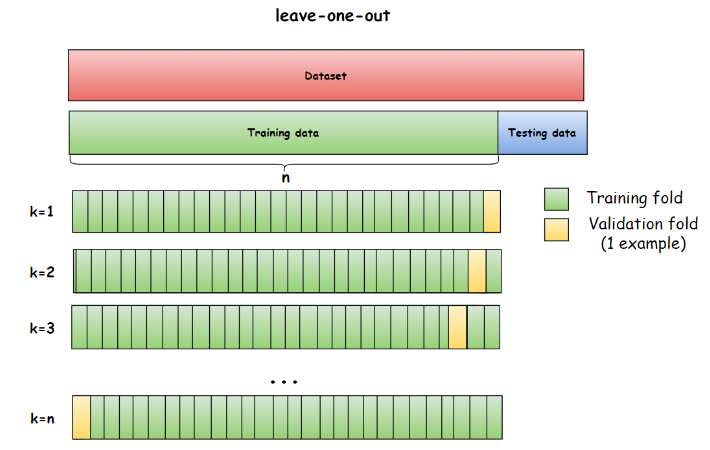

**Преимущества**:
* Идеально подходит для небольших датасетов (менее 100 примеров).
* Поскольку все доступные данные используются как для обучения, так и для валидации, значения метрик наиболее объективны и надёжны.

**Недостатки**:
* Подход предусматривает, что мы обучаем одну и ту же модель n раз. Очевидно, что чем больше примеров в обучающем наборе данных, тем больше моделей мы будем обучать. Поэтому метод не подходит для оценки качества модели на больших наборах данных, поскольку становится очень ресурсозатратным.

In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


### Сравнение методов валидации

СХЕМА ВАЛИДАЦИИ	| ПРЕИМУЩЕСТВА	| НЕДОСТАТКИ	| ФУНКЦИЯ В SKLEARN
--|--|--|--
hold-out | Очень простой и понятный. <br> Данный метод чаще всего применяется в случае больших датасетов в силу того, что требует значительно меньше вычислительных мощностей, чем другие методы. | Разбиение производится случайным образом, и оценка в этом методе зависит от того, какие наблюдения попали в набор для валидации. | **train_test_split()**
k-fold	| Более устойчивая к выбросам оценка качества модели. <br> Значения метрик получаются более объективными, чем в hold-out. | Обучаем одну и ту же модель k раз, что плохо сказывается на производительности. Если модель обучается медленно, то валидация может занять очень много времени. | K**Fold + cross_validate()**
leave-one-out | Идеально подходит для небольших датасетов (менее 100 примеров). <br>  Поскольку все доступные данные используются как для обучения, так и для валидации, значения метрик наиболее объективны и надёжны. | Обучаем одну и ту же модель n раз. <br> Поэтому метод не подходит для оценки качества модели на больших наборах данных, так как становится очень ресурсозатратным. | **LeaveOneOut + cross_validate()**